# Analyzing ringing waveforms

## Intro

Ideal waveforms with no ringing can be integrated over some section. Such an approach doesn't work well with ringing waveforms since small time domain shifts can result in sizable differences in integrated areas.

Analogy: One can estimate the energy delivered by smacking a large bell either measuring the physical displacement of the bell, or by measuring the amplitude of the sound emitted. 

## Loading Libraries

In [23]:
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
import pickle
from scipy import stats
from scipy.stats.mstats import theilslopes
from scipy.signal import medfilt
from scipy.signal import savgol_filter
import os

## Initializing Data

### Loading Data

In [24]:
#Load text data
hsdpd1data = loadtxt("sxrx21715-run0192-HSDPD1.txt")
acqpd1data = loadtxt("sxrx21715-run0192-AcquirisPD1.txt")
blddata = loadtxt("sxrx21715-run0192.txt")

## Visualizing Some Sample Data from the high speed digitizer (hsd)

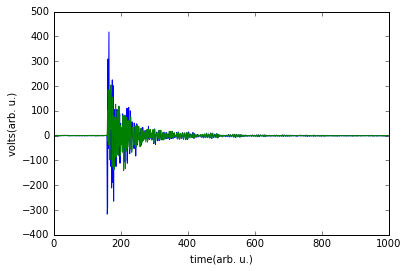

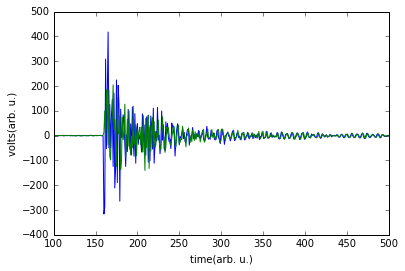

In [74]:
#plot some sample data
#my_waveform_key = 'hsd/ch0/full_waveform'
#ch0_waves = array([i-mean(i[:300]) for i in my_dict[my_waveform_key]])# subtracting off offset
ch0_waves = hsdpd1data-mean(hsdpd1data[:130]) # subtracting off offset
plot(ch0_waves[0])
plot(ch0_waves[100])
xlabel("time(arb. u.)")
ylabel("volts(arb. u.)")
show()

plot(ch0_waves[0])
plot(ch0_waves[100])
xlim(100,500)
xlabel("time(arb. u.)")
ylabel("volts(arb. u.)")
show()
#np.savetxt('sxrx21715pd1waveform1hsdr192.txt',ch0_waves[0])
#np.savetxt('sxrx21715pd1waveform2hsdr192.txt',ch0_waves[100])

### Calculating Eiegen Waveform using SVD

In [91]:
##############################
##############################
#singular value decomposition on background shots. variable v contains the eigen backgrounds
#u,s,v = svd(ch0_waves) don't use this. it will crash computer unless a small section of the waveforms is chosen
##############################
##############################

start,end = (250,650)  #which section of waveform to use for svd.  use to select out saturation region

#instead manually calculate svd by using the smaller lh sv.
s,u = eig(dot(ch0_waves[:500,start:end],ch0_waves[:500,start:end].transpose()))
v = dot(pinv(u),ch0_waves[:500,start:end])



In [92]:
temp = array([i/dot(i,i)**0.5 for i in v[:25]])#normalizing
v = real(temp)
print(dot(v[0],v[0])) #validating orthogonality
print(dot(v[1],v[1])) #validating orthogonality
print(dot(v[0],v[1])) #validating orthogonality
print(dot(v[0],v[2])) #validating orthogonality
print(dot(v[1],v[2])) #validating orthogonality

1.0
1.0
1.11022302463e-16
-5.55111512313e-17
5.89805981832e-16


####  dominant eigen waveform

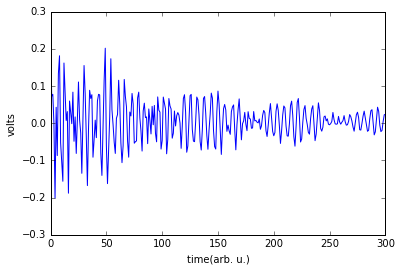

In [93]:
#showing some of the eigen backgrounds
plot(v[0])
xlim(0,300)
xlabel("time(arb. u.)")
ylabel("volts")
show()

####  next dominant eigen waveform

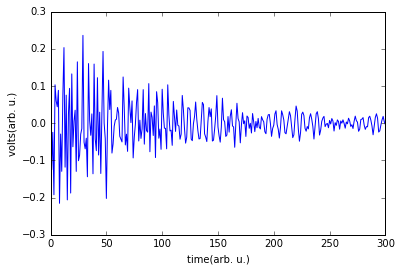

In [94]:
plot(v[1])
xlim(0,300)
xlabel("time(arb. u.)")
ylabel("volts(arb. u.)")
show()

### calculating projections of data onto eigen basis (the domintant weight is proporational to the amplitude)

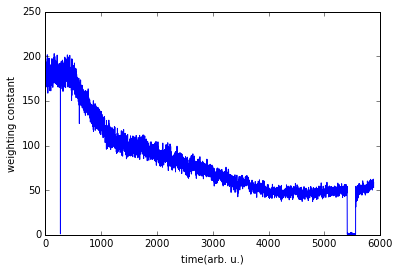

In [95]:
#calculating and showing the weights. x-axis is event number
my_weights = real(dot(ch0_waves[:,start:end],v[:25].transpose()))
my_weights.shape
plot((my_weights[:,0]**2+my_weights[:,1]**2+my_weights[:,2]**2)**0.5)#the weight of each event #
xlabel("time(arb. u.)")
ylabel("weighting constant")
show()

### contribution from each mode

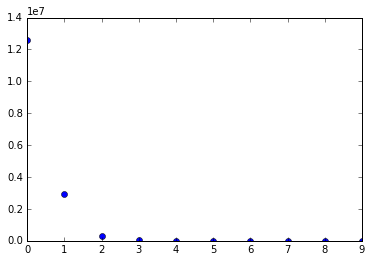

In [96]:
plot(real(s[:10]),'o') #this plot indicates first 4 modes account for 99% of variance
show()

### comparing reconstructed and original wave form

In [97]:
#reconstructed = dot(my_weights.transpose(),v)
reconstructed = sum(my_weights[0][i]*v[i] for i in arange(2)) #0th waveform calculated from first 2 eigen waveforms

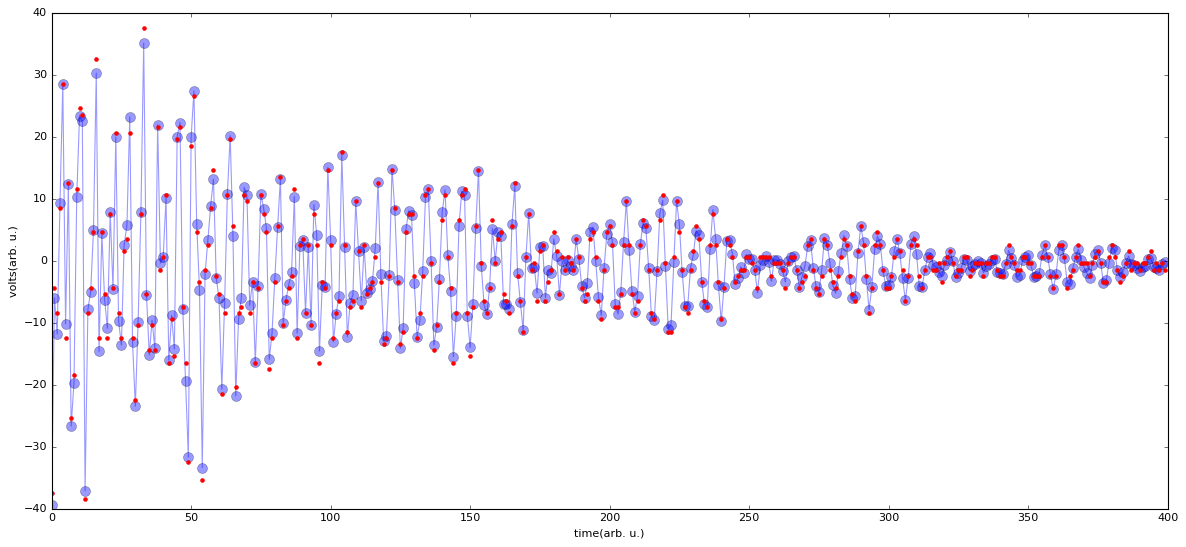

In [98]:
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
plot(reconstructed,'-o',alpha=0.4,markersize=9)
plot(ch0_waves[0,start:end],'r.',markersize=7) #original data set
#xlim(50,200)
#xlim(2000,2200)
xlabel("time(arb. u.)")
ylabel("volts(arb. u.)")
show()

### spectral density of eigen waveforms

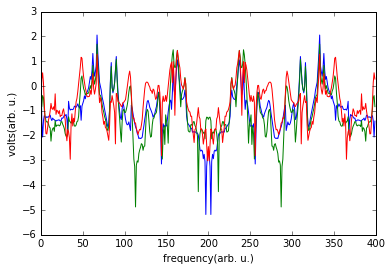

191.910573938
191.814270461


In [99]:
plot(log(abs(fft(v[0]))))
plot(log(abs(fft(v[1]))))
plot(log(abs(fft(v[2]))))
xlabel("frequency(arb. u.)")
ylabel("volts(arb. u.)")
show()
print(sum((abs(fft(v[0]))[50:200])**2))
print(sum((abs(fft(v[1]))[50:200])**2))

### plotting against another intensity metric (e.g. the split off signal sent to the acqiris)

#### sample waveform

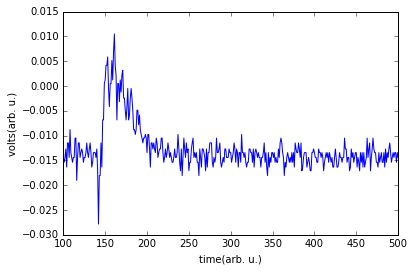

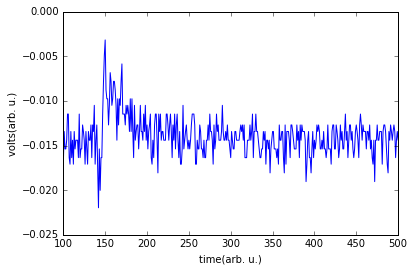

In [100]:
#ch1_waves = array([i-mean(i[:300]) for i in my_dict['acq02/ch1/full_waveform']])# subtracting off offset
ch1_waves = acqpd1data #-mean(acqpd1data[:130])
plot(ch1_waves[0]) #,'.'
xlim(100,500)
xlabel("time(arb. u.)")
ylabel("volts(arb. u.)")
show()
plot(ch1_waves[1000]) #,'.'
xlim(100,500)
xlabel("time(arb. u.)")
ylabel("volts(arb. u.)")
show()
#np.savetxt('sxrx21715pd1waveformacqr192.txt',ch1_waves[0])

#### svd of acqiris2

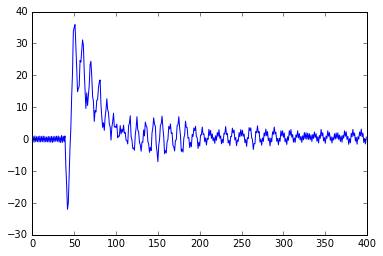

In [154]:
acq2_ch1_average = sum(ch1_waves[:,100:500]-mean(ch1_waves[:,:130]),axis=0)
plot(acq2_ch1_average)
show()

In [172]:
##############################
##############################
#singular value decomposition on background shots. variable v contains the eigen backgrounds
#u,s,v = svd(ch0_waves) don't use this. it will crash computer unless a small section of the waveforms is chosen
##############################
##############################

start,end = (100,500)  #which section of waveform to use for svd.  use to select out saturation region

#instead manually calculate svd by using the smaller lh sv.
ch1_waves-=mean(ch1_waves)
s_acq,u_acq = eig(dot(ch1_waves[:500,start:end],ch1_waves[:500,start:end].transpose()))
v_acq = dot(pinv(u),ch1_waves[:500,start:end])

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


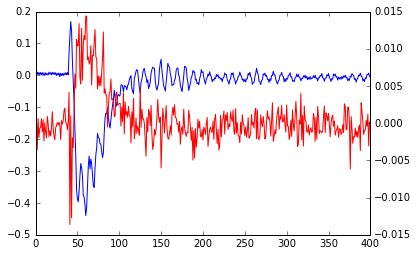

In [173]:
plot(v_acq[0])
twinx()
plot(v_acq[1],'r')
show()

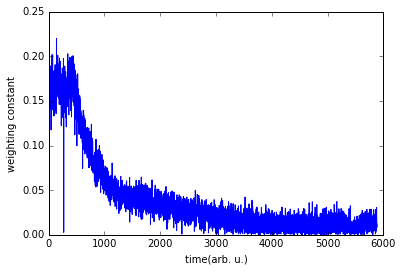

In [176]:
acq_weights = real(dot(ch1_waves[:,start:end],v_acq[:25].transpose()))
plot((acq_weights[:,0]**2+acq_weights[:,1]**2+acq_weights[:,2]**2)**0.5)#the weight of each event #
xlabel("time(arb. u.)")
ylabel("weighting constant")
show()

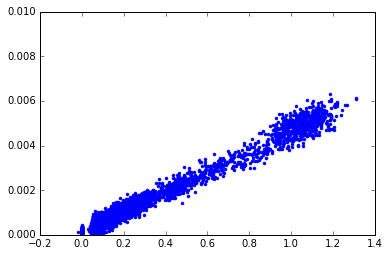

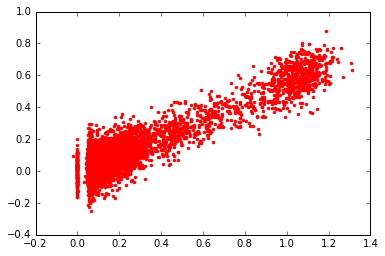

In [185]:
plot(gdetc,(0*acq_weights[:,0]**2+acq_weights[:,1]**2)**0.5,'.')
ylim(0,1e-2)
show()
plot(gdetc,acq2_ch1_area,'r.')
show()

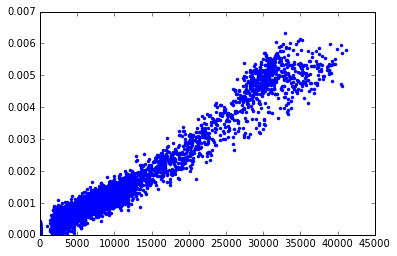

In [188]:
plot((my_weights[:,0]**2+my_weights[:,1]**2+my_weights[:,2]**2)**1,(0*acq_weights[:,0]**2+acq_weights[:,1]**2)**0.5,'.')
show()

#### integrated area. x a-xis is the event number

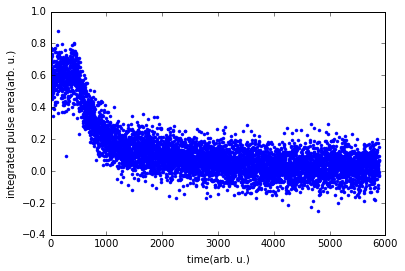

In [101]:
acq2_ch1_area = sum(ch1_waves[:,100:250]-mean(ch1_waves[:,:130]),axis=1)
plot(acq2_ch1_area,'.')
xlabel("time(arb. u.)")
ylabel("integrated pulse area(arb. u.)")
show()

#### comparing integrated acq area with hsd eigen waveform weighting

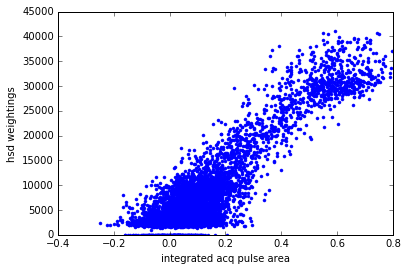

In [103]:
plot(acq2_ch1_area,(my_weights[:,0]**2+my_weights[:,1]**2+my_weights[:,2]**2)**1,'.')
#my_cov = cov(acq2_ch4_area,my_weights[:,0])
#plot(acq2_ch4_area,mean(my_weights[:,0])+(acq2_ch4_area-mean(acq2_ch4_area))*(my_cov[1,0]/my_cov[0,0]))
plot(arange(0,0.3),mean((my_weights[:,0]**2+my_weights[:,1]**2+my_weights[:,2]**2)**0.5/acq2_ch1_area)*arange(0,0.3)) #my_weights[:,0]
xlim(-0.4,0.8)
#ylim(0,1200)
xlabel("integrated acq pulse area")
ylabel("hsd weightings")
show()

## fourier analysis. looking at spectral power content of ringing (instead of svd)

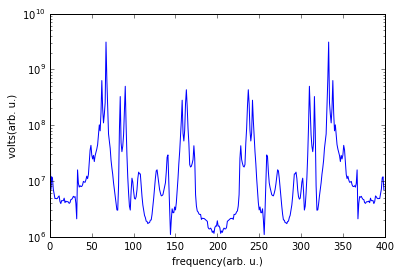

In [104]:
plot(sum(abs(fft(ch0_waves[:,start:end],axis=1))**2,axis=0)) #the power spectrum summed over all runs
semilogy()
xlabel("frequency(arb. u.)")
ylabel("volts(arb. u.)")
show()

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 400 but corresponding boolean dimension is 5885


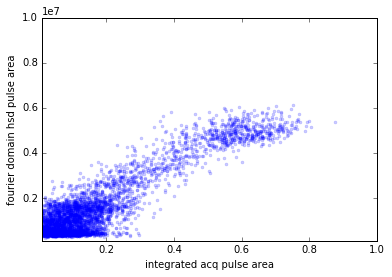

In [142]:
my_mask = array([False for i in ch0_waves])
my_mask[50:80] = True
my_mask[150:180] = True
power_densities = sum(abs(fft(ch0_waves[:,start:end],axis=1))[:,my_mask]**2,axis=1)**1
plot(acq2_ch1_area,power_densities,'.',alpha=0.2)#comparing to another acqiris channel
#my_cov = cov(acq2_ch4_area,power_densities)
#plot(acq2_ch4_area,mean(power_densities)+(acq2_ch4_area-mean(acq2_ch4_area))*(my_cov[1,0]/my_cov[0,0]))
plot(arange(0,1),mean(power_densities/acq2_ch1_area)*arange(0,1))
xlim(1e-2,1)
ylim(1e5,1e7)
#loglog()
#ylim(0,7000)
xlabel("integrated acq pulse area")
ylabel("fourier domain hsd pulse area")
show()


#comparing hsd eigen waveform weighting of pd1 with attenuator * gas detector 1

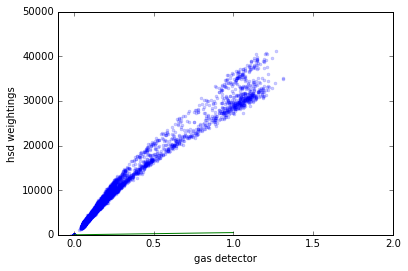

In [151]:
gdetc = blddata[:,1]*0.5*(blddata[:,2]+blddata[:,3])
plot(gdetc,(my_weights[:,0]**2+my_weights[:,1]**2+my_weights[:,2]**2)**1,'.',alpha=0.2) #
#my_cov = cov(acq2_ch4_area,my_weights[:,0])
#plot(acq2_ch4_area,mean(my_weights[:,0])+(acq2_ch4_area-mean(acq2_ch4_area))*(my_cov[1,0]/my_cov[0,0]))
plot(arange(0,2),mean((my_weights[:,0]**2+my_weights[:,1]**2)**0.5/gdetc)*arange(0,2)) #my_weights[:,0]
xlim(-0.1,2)
ylim(0,5e4)
xlabel("gas detector")
ylabel("hsd weightings")
show()


#comparing integrated acquiris pd1 data with attenuator * gas detector 1

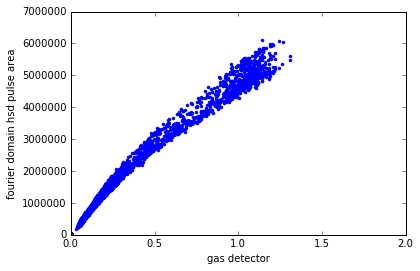

In [146]:
#gdetc = blddata[:,1]*0.5*(blddata[:,2]+blddata[:,3])
plot(gdetc,power_densities,'.') 
#my_cov = cov(acq2_ch4_area,my_weights[:,0])
#plot(acq2_ch4_area,mean(my_weights[:,0])+(acq2_ch4_area-mean(acq2_ch4_area))*(my_cov[1,0]/my_cov[0,0]))
#plot(arange(0,1.2),mean(power_densities)/mean(gdetc)*arange(0,1.2)) #my_weights[:,0]
#semilogy()
#semilogx()
xlim(0.0,2)
#ylim(0,5000)
xlabel("gas detector")
ylabel("fourier domain hsd pulse area")
show()


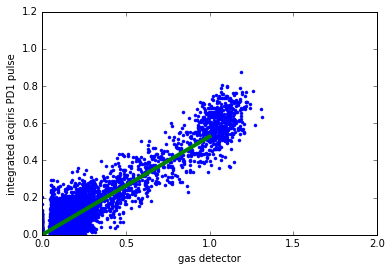

In [149]:
#gdetc = blddata[:,1]*0.5*(blddata[:,2]+blddata[:,3])
plot(gdetc,acq2_ch1_area,'.') 
#my_cov = cov(acq2_ch4_area,my_weights[:,0])
#plot(acq2_ch4_area,mean(my_weights[:,0])+(acq2_ch4_area-mean(acq2_ch4_area))*(my_cov[1,0]/my_cov[0,0]))
plot(arange(0,1.2),mean(acq2_ch1_area)/mean(gdetc)*arange(0,1.2),linewidth=4) #my_weights[:,0]
#semilogy()
#semilogx()
xlim(0,2)
ylim(0,1.2)
xlabel("gas detector")
ylabel("integrated acqiris PD1 pulse")
show()
#np.savetxt('sxrx21715gdetcr192.txt',gdetc)
#np.savetxt('sxrx21715pd1acqr192.txt',acq2_ch1_area)

In [84]:
pd1waves =np.vstack((ch0_waves[0], ch1_waves[0]))
pd1wavest = np.transpose(pd1waves)
pd1intensities = np.vstack((gdetc, acq2_ch1_area,power_densities))
pd1intensitiest = np.transpose(pd1intensities)
np.savetxt('pd1wfr192.txt',pd1wavest)
np.savetxt('pd1intr192.txt',pd1intensitiest)